In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data 1_6.csv')

In [ ]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [ ]:
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size
test_data_og=df1[train_size:]

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test


train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 4s 75ms/step - loss: 0.0956 - val_loss: 0.0566
Epoch 2/100
21/21 [==============================] - 1s 55ms/step - loss: 0.0139 - val_loss: 0.0087
Epoch 3/100
21/21 [==============================] - 2s 85ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 4/100
21/21 [==============================] - 2s 84ms/step - loss: 6.6332e-04 - val_loss: 9.7580e-05
Epoch 5/100
21/21 [==============================] - 2s 82ms/step - loss: 4.8202e-04 - val_loss: 9.1810e-05
Epoch 6/100
21/21 [==============================] - 1s 51ms/step - loss: 4.4260e-04 - val_loss: 1.3478e-04
Epoch 7/100
21/21 [==============================] - 1s 50ms/step - loss: 4.2177e-04 - val_loss: 1.4466e-04
Epoch 8/100
21/21 [==============================] - 1s 52ms/step - loss: 4.0162e-04 - val_loss: 1.3855e-04
Epoch 9/100
21/21 [==============================] - 1s 51ms/step - loss: 3.9008e-04 - val_loss: 1.4071e-04
Epoch 10/100
21/21 [==============================] 

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 14ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 15883.366899416971


In [ ]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99956502656843
Testing MAE: 15814.66228286001


In [ ]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.04804936796426773], [0.04737472161650658], [0.04653105512261391], [0.04562259092926979], [0.0446782112121582], [0.04370742291212082], [0.04271526262164116], [0.04170534387230873], [0.040680430829524994], [0.03964272141456604], [0.03859391063451767], [0.03753536567091942], [0.03646820783615112], [0.03539334237575531], [0.03431154042482376], [0.03322342038154602], [0.032129500061273575], [0.03103022463619709], [0.029925957322120667], [0.02881699614226818], [0.027703601866960526], [0.026585986837744713], [0.02546432614326477], [0.024338776245713234], [0.0232094619423151], [0.02207648754119873], [0.020939940586686134], [0.019799910485744476], [0.018656454980373383], [0.01750962994992733], [0.01635948196053505], [0.015206050127744675], [0.014049377292394638], [0.01288948580622673], [0.011726411059498787], [0.010560179129242897], [0.009390810504555702], [0.00821832474321127], [0.007042746525257826], [0.005864088423550129], [0.0046823713928461075], [0.0034976094029843807], [0.002309822943

In [ ]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[14195.62189975],
       [14140.22264026],
       [14070.94412245],
       [13996.34467675],
       [13918.7959919 ],
       [13839.07873985],
       [13757.60650544],
       [13674.67601742],
       [13590.514258  ],
       [13505.30171168],
       [13419.17756566],
       [13332.25408743],
       [13244.62335467],
       [13156.35970253],
       [13067.52645352],
       [12978.17438805],
       [12888.34602703],
       [12798.07792623],
       [12707.39991146],
       [12616.33645522],
       [12524.90897091],
       [12433.13489517],
       [12341.02860558],
       [12248.60295019],
       [12155.86817686],
       [12062.83285093],
       [11969.50416122],
       [11875.88944945],
       [11781.99345717],
       [11687.82077297],
       [11593.37522067],
       [11498.66001229],
       [11403.67866574],
       [11308.43301646],
       [11212.92597056],
       [11117.15966938],
       [11021.13579539],
       [10924.85595461],
       [10828.32217367],
       [10731.53548499],


In [ ]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = test_data_og[-101:]
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [ ]:
print(y_pred_with_test_data.shape)
test_data.shape

(160,)


(160, 1)

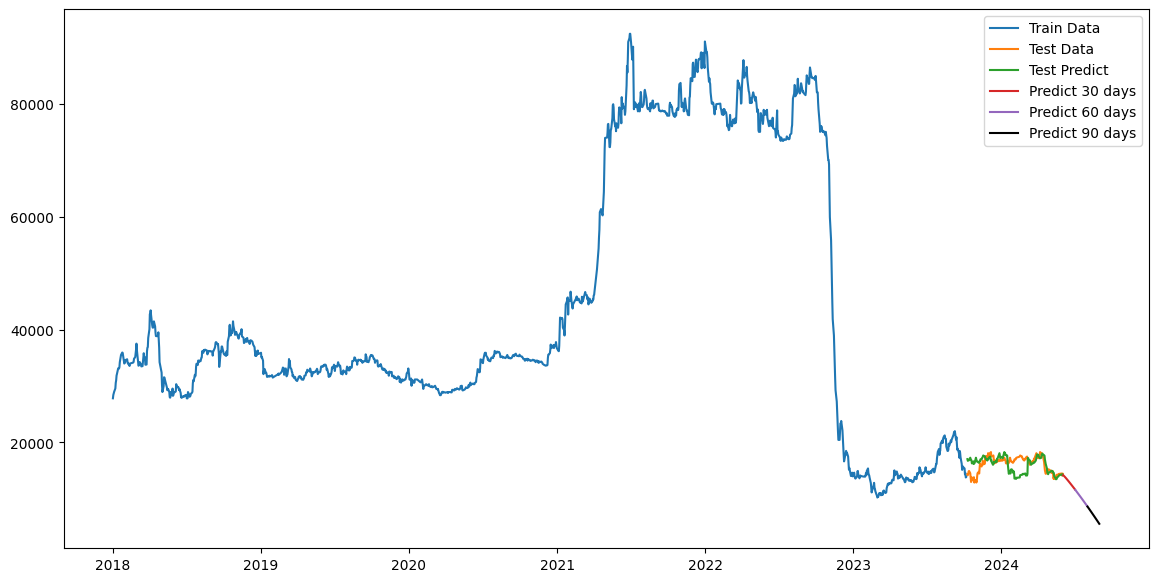

In [ ]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()